In [2]:
import librosa
import numpy as np
import time
import threading
import queue
import pickle
import pandas as pd

########### PARAMETERS ###########
# DO NOT MODIFY
# Desired sample rate 16000 Hz
sample_rate = 16000
# Frame length
frame_length = 512



########### AUDIO FILE ###########
# DO NOT MODIFY
# Path to the audio file
# audio_file = "test_aaico_challenge.wav"
audio_file = "audio_aaico_challenge.wav"                                                    #! ----------------> Change to this line to test the audio file

# Read the audio file and resample it to the desired sample rate
audio_data, current_sample_rate = librosa.load(
    audio_file, 
    sr=sample_rate,
)
audio_data_int16 = (audio_data * 32767).astype(np.int16)
number_of_frames = len(audio_data_int16) // frame_length
audio_data_int16 = audio_data_int16[:number_of_frames * frame_length]
audio_duration = len(audio_data_int16) / sample_rate


########### STREAMING SIMULATION ###########
# DO NOT MODIFY
results = np.zeros(shape=(3, len(audio_data_int16)), dtype=np.int64)
# Detection mask lines are SENT TIME, LABEL, RECEIVE TIME. 
buffer = queue.Queue()
start_event = threading.Event()

def label_samples(list_samples_id, labels):
    receive_time = time.time_ns()
    results[1][list_samples_id] = labels
    results[2][list_samples_id] = receive_time

def notice_send_samples(list_samples_id):
    send_time = time.time_ns()
    results[0][list_samples_id] = send_time

def emit_data(): 
    time.sleep(.5)
    print('Start emitting')
    start_event.set()
    for i in range(0, number_of_frames):
        list_samples_id = np.arange(i*frame_length, (i+1)*frame_length)
        time.sleep(frame_length / sample_rate) # Simulate real time
        frame = audio_data_int16[list_samples_id]
        buffer.put(frame)
        notice_send_samples(list_samples_id)
    print('Stop emitting')

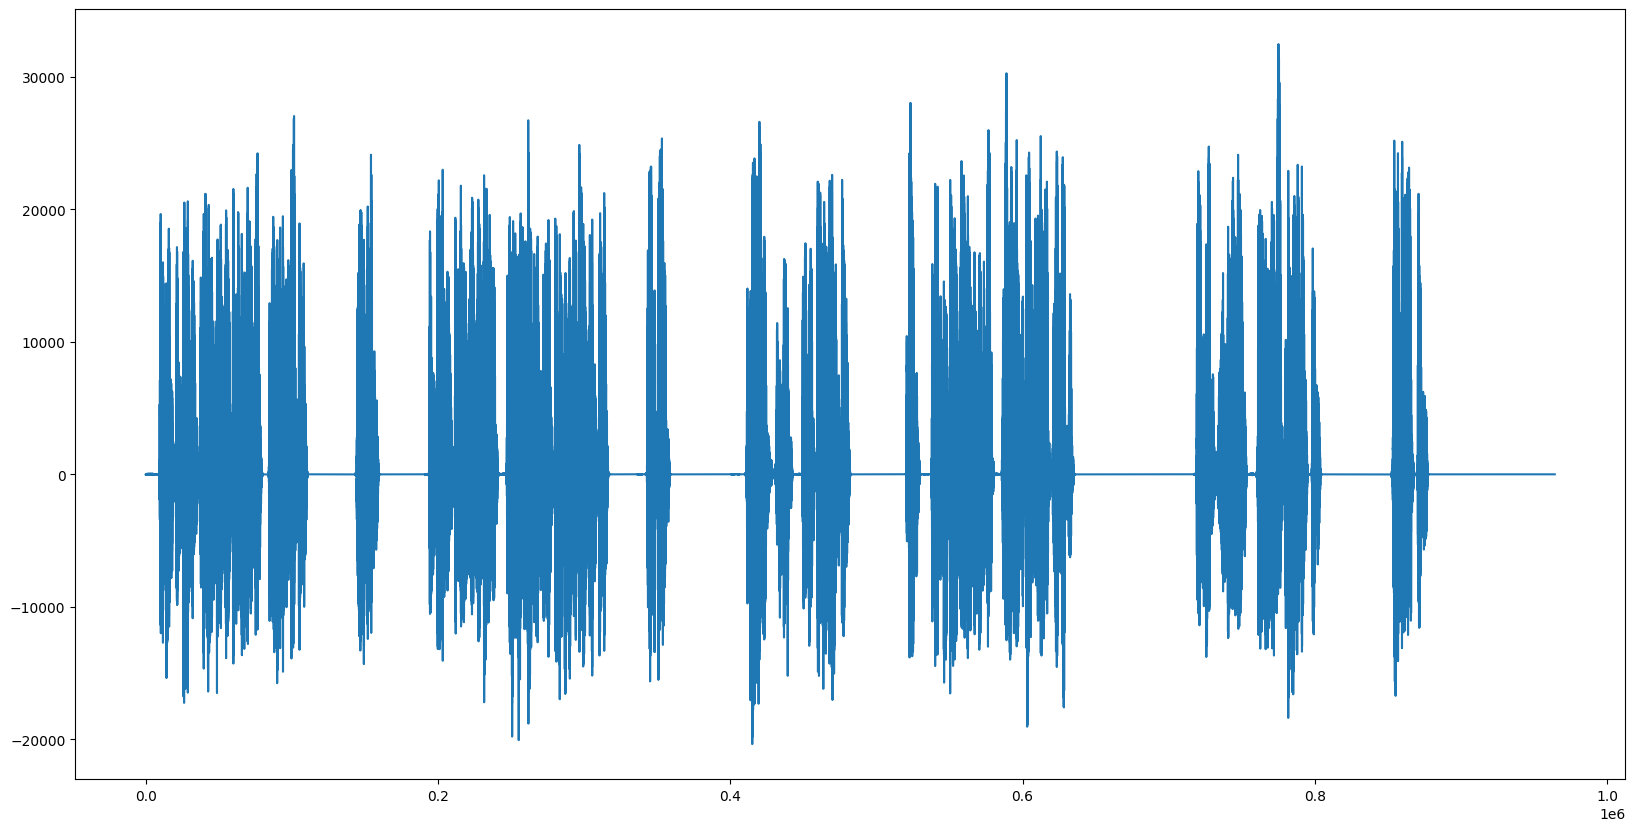

In [11]:
audio_data = pd.DataFrame(audio_data_int16)

# visualize the audio data
import matplotlib.pyplot as plt
plt.plot(audio_data)
plt.gcf().set_size_inches(20, 10)
plt.show()

## Galactic Temperature

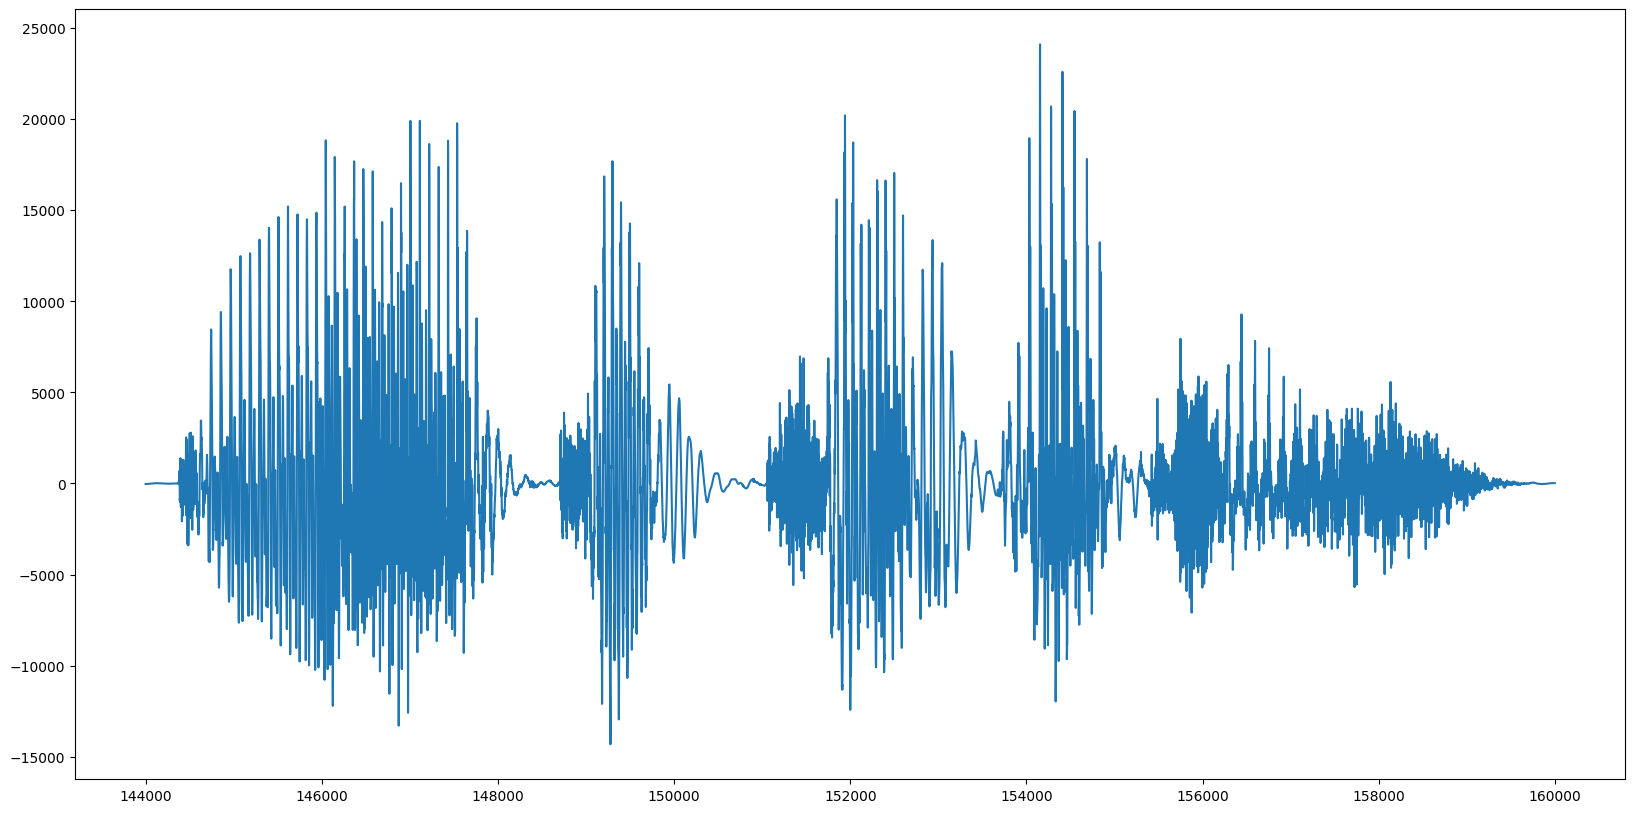

In [13]:
# visualize the audio between the 9 and 10 second mark
plt.plot(audio_data[9*sample_rate:10*sample_rate])
# set figure size for display
plt.gcf().set_size_inches(20, 10)
plt.title('Galactic Temperature')
plt.show()

In [21]:
# set that part of audio as a "galactic temperature" audio
galactic_temperature = audio_data[9*sample_rate:10*sample_rate]

galactic_temperature_numpy = galactic_temperature.to_numpy()

# save the audio as a .wav file
from scipy.io import wavfile
wavfile.write('galactic_temperature.wav', sample_rate, galactic_temperature_numpy)

# play the audio using ipython.display
from IPython.display import Audio
Audio('galactic_temperature.wav')


In [ ]:
def process_data():
    i = 0
    start_event.wait()
    print('Start processing')
    while i != number_of_frames:
        frame = buffer.get()
        
        ### TODO: YOUR CODE
        # MODIFY
        list_samples_id = np.arange(i*frame_length, (i+1)*frame_length)
        labels = [1 for _ in range(len(list_samples_id))]
        ###

        label_samples(list_samples_id, labels)
        i += 1
    print('Stop processing')
    # Save the list to a file
    with open('results.pkl', 'wb') as file:
        pickle.dump(results, file)

In [ ]:
if __name__ == "__main__": 
    time_measurement = []

    thread_process = threading.Thread(target=process_data)
    thread_emit = threading.Thread(target=emit_data)
    
    thread_process.start()
    thread_emit.start()